$$
\newcommand{\mps}[0]{\frac{\text{m}}{\text{s}}}
\newcommand{\vx}[0]{\mathbf{x}}
\newcommand{\vy}[0]{\mathbf{y}}
\newcommand{\tD}[0]{\mathbf{c}^2}
\newcommand{\tDinv}[0]{\mathbf{c}^{-2}}
\newcommand{\eas}[1]{\begin{pmatrix}
x_{#1} \\
y_{#1}
\end{pmatrix}}
$$

# GEASI Demonstration

For this demonstration, we assume the isotropic eikonal equation to compute the activation times $\phi: \Omega \to \mathbb{R}$ given a velocity function $c: \Omega \to \mathbb{R}$.It is given by
$$
\left\lVert \nabla \phi (x, y) \right\rVert = c^{-1}(x, y).
$$

To solve the equation, we additionally introduce boundary conditions with $N$ values $t_i$ already prescribed
at the position 
$\eas{i}$ for $i = 1, \ldots, N$. The condition reads as:
$$
\phi(x_i, y_i) = t_i,
$$
which we usually call the earliest activation sites (EAS). The aim now is to minimize the discrete SSE on a measurable subdomain $\Gamma \subset \Omega$ on the 
$$
\min_{x_i, y_i, t_i} \frac{1}{2} \sum_{x, y \in \Gamma} \left(\phi(x, y) - \hat{\phi}(x, y) \right)^2
$$
For further details on the algorithm, together with thorough explanations, we refer to the paper (see [README](.))

In [1]:
#Activating the notebook backend will give extra control over the plots in jupyter-notebook when executing
#%matplotlib notebook
#This backend keeps the figures in the .ipynb file
%matplotlib inline

import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import skfmm
import matplotlib.pyplot as plt
from utils import * #Utility functions defined in a separate file to keep the code short
plt.rcParams['figure.figsize'] = [11, 8]
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['text.usetex'] =  True

# Parameters

We define our grid here with an extent and a specified resolution which will define our grid spacing (dx or h) to be extent/resolution. The velocity function over the domain will be similar to the presented one in the paper: $c(x, y) = (2.9 + \sin(x) + \cos(y))^{-1}$ in $\mps$.

In [2]:
grid_resolution = 75
grid_extent = 20

In [3]:
velocity_func = lambda x, s=2.9: 1. / (s + np.sin(x[..., 0]) + np.cos(x[..., 1]))
grid_x = np.linspace(0, grid_extent, num=grid_resolution)
grid = np.stack(np.meshgrid(grid_x, grid_x, indexing='ij'), axis=-1)
grid_flat = grid.reshape([-1, 2])
vel_field = np.sqrt(velocity_func(grid))
dx = grid[1, 0, 0] - grid[0, 0, 0]

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


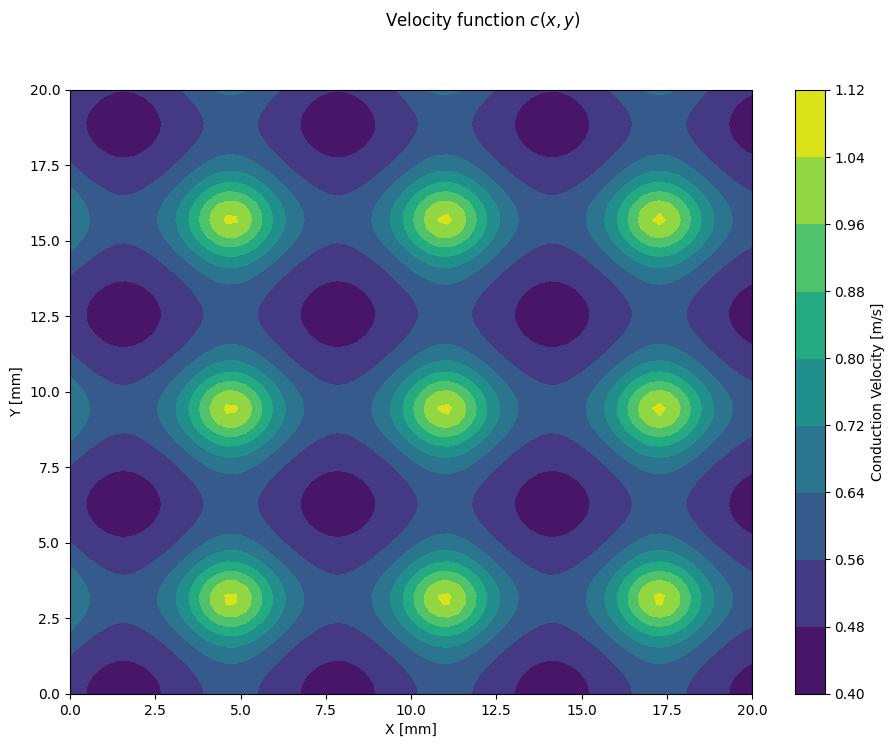

In [4]:
fig = plt.figure()
plt.contourf(grid[..., 0], grid[..., 1], vel_field)
fig.suptitle("Velocity function $c(x, y)$")
cbar = plt.colorbar()
cbar.set_label("Conduction Velocity [m/s]")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
fig.show()

# Measurement Domain $\Gamma$

Our measurement Domain $\Gamma$ is here simply defined as the boundary points of the grid $\Omega$.

In [5]:
#Create the measurement domain
gamma = np.any(np.isclose(grid, 0.) | np.isclose(grid, grid_extent), axis=-1)
gamma_flat = np.any(np.isclose(grid_flat, 0.) | np.isclose(grid_flat, grid_extent), axis=-1)

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


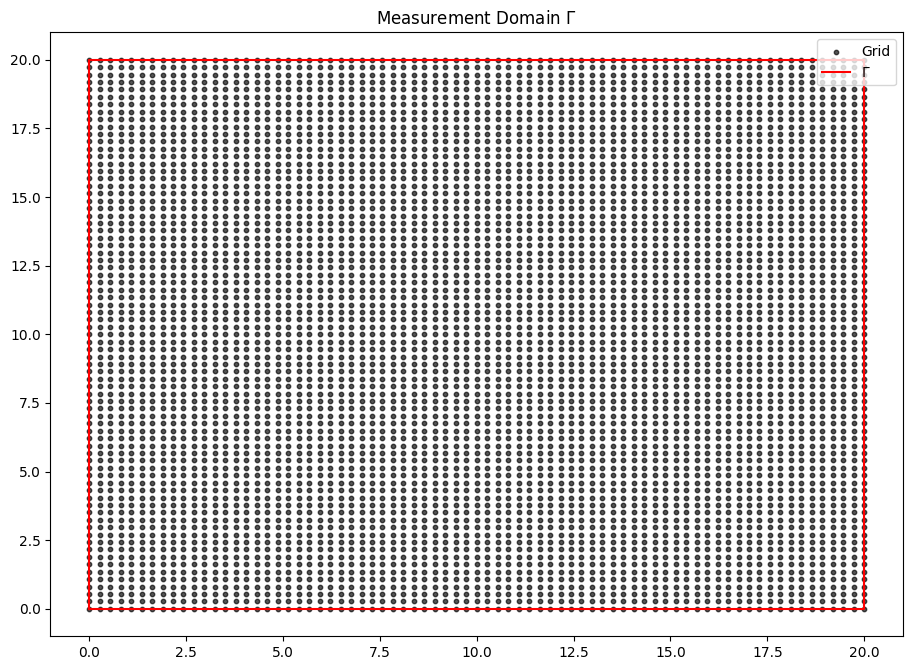

In [6]:
fig = plt.figure()
plt.title("Measurement Domain $\Gamma$")
scatter_h = plt.scatter(grid[..., 0], grid[..., 1], color='k', alpha=2/3, marker='o', s=10)
gamma_h = plt.plot([0, 0, grid_extent, grid_extent, 0], [0, grid_extent, grid_extent, 0, 0], color='r')
plt.legend([scatter_h, gamma_h[0]], ["Grid", "$\Gamma$"])
fig.show()

# Constraints

We define constraints on both $t_i \in [-1, 10]$ as well as $\eas{i} \in [0, \text{grid_extent}]^2$. While the latter is necessary to have valid boundary conditions for the eikonal problem, the former could be omitted. We also define the projection operator, which will be later used in the geodesic ODE to project points onto the grid that violate the second condition.

In [7]:
t_bounds = [-1., 10.]
xi_bounds = np.stack([[0., 0.], [grid_extent, grid_extent]])
proj_op = lambda x: np.minimum(grid_extent, np.maximum(0., x))

# Setup

The chosen setup reflects the square domain experiment in the paper, with the same initial values. The different solver (skfmm) and a discretization on the grid may alter some of the computation. The target ground-truth $\hat{\phi}$ that we want to find is generated using the same method with different timings and locations.

In [8]:
#Initialize
nr_xi = 3
xi_init =  np.array([[1 / 6., 4.1/5.], [4 / 5,  2 / 3], [1/ 4, 1 / 2.]])[:nr_xi] * grid_extent
ti_init = np.array([2., 0., 5.])[:nr_xi]
xi_ground_truth =  np.array([[1/ 3., 1/ 4.], [3/4, 1 / 3.], [2.2/5, 4/5]])[:nr_xi] * grid_extent
#xi_ground_truth[..., 1] = grid_extent - xi_ground_truth[..., 1]
ti_ground_truth = np.array([0, 5, 10])[:nr_xi]

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


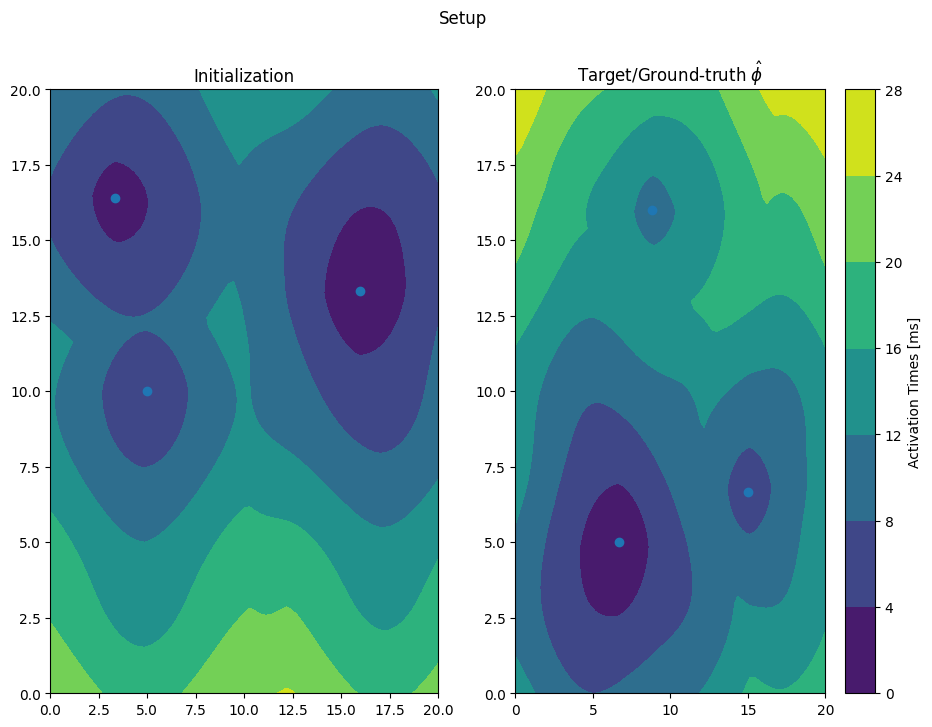

In [9]:
phi_init = computeEikonal(xi_init, ti_init, grid, vel_field)
phi_ground_truth = computeEikonal(xi_ground_truth, ti_ground_truth, grid, vel_field)
level_lines = np.linspace(0., 28., num=8)
nabla_phi_init = computeEikonalGradient(phi_init, grid, vel_field)
nabla_phi_gt = computeEikonalGradient(phi_ground_truth, grid, vel_field)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.suptitle("Setup")
axes[0].contourf(grid[..., 0], grid[..., 1], phi_init, level_lines)
axes[0].scatter(xi_init[..., 0], xi_init[..., 1])
axes[0].set_title("Initialization")

gt_p = axes[1].contourf(grid[..., 0], grid[..., 1], phi_ground_truth, level_lines)
axes[1].scatter(xi_ground_truth[..., 0], xi_ground_truth[..., 1])
#axes[1].quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
#               nabla_phi_gt[::subsampling, ::subsampling, 0], nabla_phi_gt[::subsampling, ::subsampling, 1])
axes[1].set_title("Target/Ground-truth $\hat{\phi}$")
cbar = plt.colorbar(gt_p)
cbar.set_label("Activation Times [ms]")
#fig.set_size_inches((9, 5))
fig.show()

# Optimization

We shortly summarize the main steps of the optimization:
- Compute the eikonal solution $\phi$ given the current EAS location
$\eas{i}$ and timings  $t_i$
- Compute all geodesics $\gamma_i$ to the i-th EAS by solving the ODE:
$$
\begin{cases}
\dot{\gamma_i}(t)=-\tD(\gamma_i(t))\nabla\phi(\gamma_i(t)),\\
\gamma_i(0)=\eas{i}
\end{cases}
$$

- Compute the variation of the geodesic distance $\delta(\mathbf{z}_i, \mathbf{z}_j)$ between all EAS locations $\mathbf{z}_i = \eas{i}$ and points $\mathbf{z}_j \in \Gamma$ to a movement $\mathbf{v}$:

$$
    \nabla_{\mathbf{z}_i}\delta(\mathbf{z}_i, \mathbf{z}_j) \cdot\mathbf{v}
    = \frac{\tDinv(\gamma(t)) \dot{\gamma}(0)}{\Vert \dot{\gamma}(0) \Vert_{\tDinv(\gamma(t))} }\cdot\mathbf{v}. 
$$
- The variation to the timing $t_i$ is simply 
$$
\nabla_{t_i} \phi(\mathbf{z}_j) = \begin{cases}
1 & \text{if there is a geodesic $\gamma$ connecting $\mathbf{z}_i$ and $\mathbf{z}_j$}
\\
0 & \text{else}
\end{cases}
$$
- In practice, this allows us to easily assemble the Jacobian matrices
$$
\mathbf{J}_{i} = 
\begin{pmatrix}
\nabla_{x_i}\delta(\mathbf{z}_i, \mathbf{z}_1)_x & \nabla_{y_i}\delta(\mathbf{z}_i, \mathbf{z}_1)_y & \nabla_{t_i} \phi(\mathbf{z}_1) \\
& \vdots & \\
\nabla_{x_i}\delta(\mathbf{z}_i, \mathbf{z}_M)_x & \nabla_{y_i}\delta(\mathbf{z}_i, \mathbf{z}_M)_y & \nabla_{t_i} \phi(\mathbf{z}_M) 
\end{pmatrix}
$$
- (Note that the Jacobian matrices $\mathbf{J}_i$ can be stacked in practice and only have non-zero entries on $\Gamma$)
- Solve the least squares problem of the linearized cost function around the current point $x_i^{(k)},y_i^{(k)},t_i^{(k)}$ with the corresponding current solution $\phi_{(k)}$ (Gauss-Newton):
$$
\min_{(x_i,y_i,t_i)_{i=1}^N}
\sum_{i=1}^N\frac{1}{2}\left\Vert \mathbf{J}_i
\begin{pmatrix}
x_i-x_i^{(k)}\\
y_i-y_i^{(k)}\\
t_i-t_i^{(k)}
\end{pmatrix}
+\phi_{(k)}(\vx)-\hat{\phi}(\vx)\right\Vert^2_{L^2(\Gamma)}.
$$
- (Note that we only take a step towards the new solution found using the Gauss-Newton algorithm)

This is a simplified representation for the isotropic eikonal equation only. For further details on the optimization, including the extension to anisotropic eikonal, please consult the paper.

The initialization along with its geodesic are shown in the figure below. The arrows indicate $\dot{\gamma_i}(t)=-\tD(\gamma_i(t))\nabla\phi(\gamma_i(t))$.

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


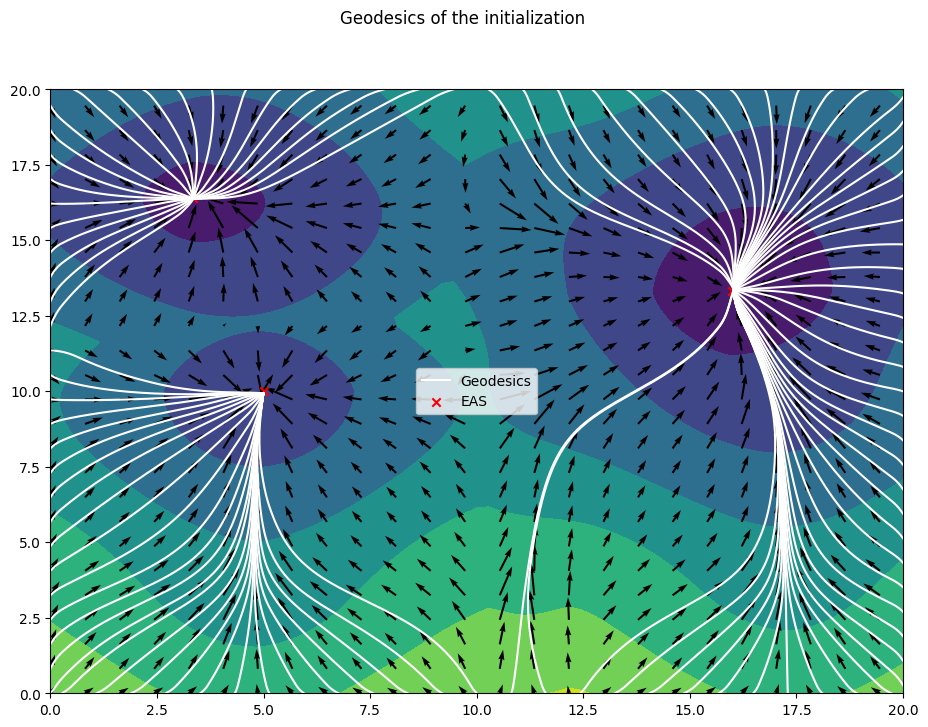

In [10]:
subsampling = grid_resolution // 25
grid_subsampled = grid[::subsampling, ::subsampling]
geodesics = computeGeodesics(nabla_phi_init, grid, grid[gamma], proj_op, alpha=1e-1)

fig = plt.figure()
fig.suptitle("Geodesics of the initialization")
plt.contourf(grid[..., 0], grid[..., 1], phi_init)
plt.quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
               nabla_phi_init[::subsampling, ::subsampling, 0], nabla_phi_init[::subsampling, ::subsampling, 1])
geodesics_h = plt.plot(geodesics[:, ::subsampling, 0], geodesics[:, ::subsampling, 1], color='w', alpha=1.)
eas_h = plt.scatter(xi_init[..., 0], xi_init[..., 1], marker='x', color='r')
#plt.scatter(geodesics[-1, ::subsampling, 0], geodesics[-1, ::subsampling, 1], color='g', marker='o', alpha=1.)
#fig.set_size_inches((9, 5))
plt.legend([geodesics_h[0], eas_h], ["Geodesics", "EAS"])
fig.show()

Calculating $\dot{\gamma}(0)$ numerically poses some challenges. Instead of calculating $\dot{\gamma}$ directly at the EAS locations, we define a small neighborhood (smaller than the grid spacing) around each EAS. $\dot{\gamma}$ is evaluated at the first intersection of the geodesic with this neighborhood. The "source-geodesics" obtained this way, are visualized in the figure below as white arrows (flipped).

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


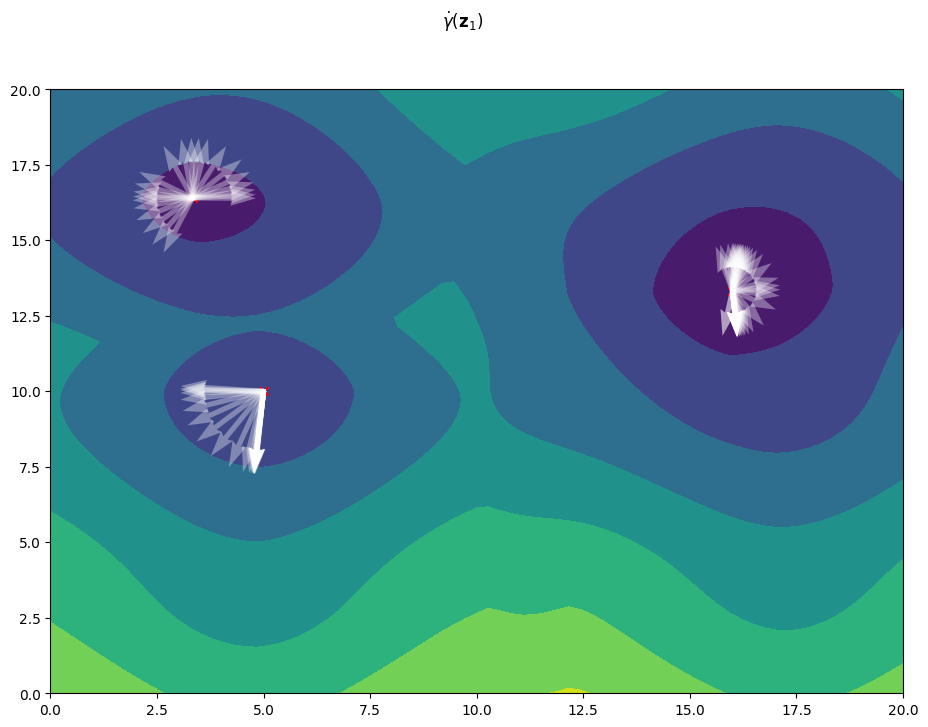

In [11]:
gamma_dot_converg, jacobian_opt = compSourceGradients(geodesics, xi_init, grid, -nabla_phi_init,
                                                     vel_field, neighborhood_eps=dx/2.)
xi_broadcast = np.tile(xi_init, [jacobian_opt.shape[0], 1, 1])
fig = plt.figure()
fig.suptitle("$\dot{\gamma}(\mathbf{z}_1)$")
plt.contourf(grid[..., 0], grid[..., 1], phi_init)
plt.scatter(xi_init[..., 0], xi_init[..., 1], marker='x', color='r')

for i in range(nr_xi):
    plt.quiver(xi_broadcast[::subsampling, i, 0], xi_broadcast[::subsampling, i, 1], 
               jacobian_opt[::subsampling, i*2], jacobian_opt[::subsampling, i*2+1], 
               color='w', alpha=.35, scale=10)
#plt.quiver(xi_broadcast[::subsampling, 1, 0], xi_broadcast[::subsampling, 1, 1], 
#           jacobian_opt[::subsampling, 2], jacobian_opt[::subsampling, 3], 
#           color='w', alpha=.35, scale=10)
#fig.set_size_inches((9, 5))
fig.show()

In [12]:
errors = []
results_xi = []
results_ti = []

xi_current = xi_init
ti_current = ti_init

nr_xi = ti_current.size
print_modulo = 5
alpha_acc = 1 / np.sqrt(2)
for opt_iter in range(50):
    
    #Save current position
    results_xi.append(xi_current)
    results_ti.append(ti_current)
    
    phi_current = computeEikonal(xi_current, ti_current, grid, vel_field)
    nabla_phi_current = computeEikonalGradient(phi_current, grid, vel_field)
    geodesics = computeGeodesics(nabla_phi_current, grid, grid[gamma], proj_op, alpha=1e-1)
    gamma_dot_converg, jacobian_opt = compSourceGradients(geodesics, xi_current, grid, nabla_phi_current,
                                                     vel_field, neighborhood_eps=dx/2.)
    
    #Least squares problem (Gauss-Newton)
    residuals = phi_current[gamma] - phi_ground_truth[gamma]
    x0 = np.concatenate([xi_current.reshape([-1], order='C'), ti_current])
    quadr_f = lambda x: 0.5 * np.sum((jacobian_opt @ (x - x0) + residuals)**2)
    quadr_grad = lambda x: jacobian_opt.T @ (jacobian_opt @ (x - x0) + residuals)
    bfgs_result = fmin_l_bfgs_b(quadr_f, x0, fprime=quadr_grad, 
                  bounds=((0, grid_extent),) * nr_xi * 2 + ((t_bounds[0], t_bounds[1]),) * nr_xi)
    
    x_new = x0 + 0.25 * (bfgs_result[0] - x0)
    xi_current = x_new[:nr_xi*2].reshape([nr_xi, 2], order='C')
    ti_current = x_new[nr_xi*2:]
    
    
    if opt_iter % print_modulo == 0:
        error_gamma = .5 * np.sum(residuals**2)
        error_omega = .5 * np.sum((phi_current - phi_ground_truth)**2)
        print("Iteration %d, SSE (Gamma): %.2e, SSE (Omega): %.2e" % (opt_iter, error_gamma, error_omega))
        
    error_omega = .5 * np.sum((phi_current - phi_ground_truth)**2)
    errors.append(error_omega)

Iteration 0, SSE (Gamma): 1.44e+04, SSE (Omega): 2.16e+05
Iteration 5, SSE (Gamma): 1.46e+02, SSE (Omega): 2.00e+04
Iteration 10, SSE (Gamma): 2.71e+02, SSE (Omega): 9.62e+03
Iteration 15, SSE (Gamma): 8.21e+01, SSE (Omega): 1.80e+03
Iteration 20, SSE (Gamma): 9.97e+00, SSE (Omega): 1.82e+02
Iteration 25, SSE (Gamma): 5.75e-01, SSE (Omega): 1.36e+01
Iteration 30, SSE (Gamma): 3.24e-02, SSE (Omega): 2.51e+00
Iteration 35, SSE (Gamma): 1.82e-03, SSE (Omega): 1.53e+00
Iteration 40, SSE (Gamma): 1.01e-04, SSE (Omega): 1.40e+00
Iteration 45, SSE (Gamma): 3.51e-06, SSE (Omega): 1.38e+00


# Result

The result of the optimization, similar to the paper, are plotted here. Note that since there are small deviations from the original algorithm, the results may vary slightly from the presented ones in the paper. In summary, we are able to find the optimal EAS location and timings with only a very minor mismatch.

Note that a small residual error can be found that is fully contained in $\Omega$, but is not visible to the optimization on $\Gamma$.

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


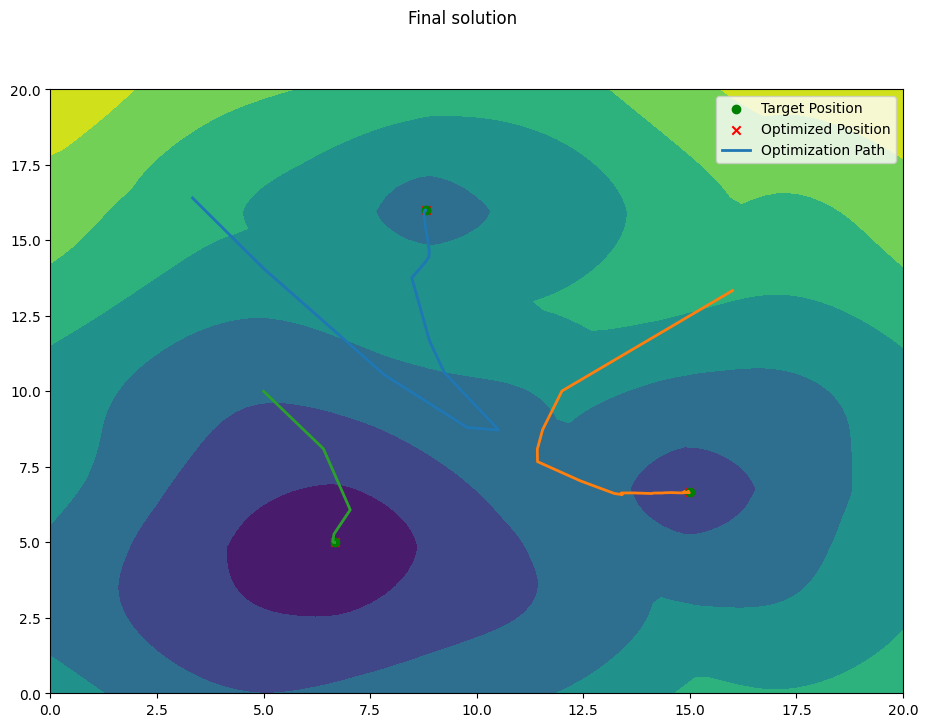

In [13]:
geodesics = computeGeodesics(nabla_phi_current, grid, grid[gamma], proj_op, alpha=1e-1)
ti_over_time = np.stack(results_ti)
xi_over_time = np.stack(results_xi)

fig = plt.figure()
fig.suptitle("Final solution")
plt.contourf(grid[..., 0], grid[..., 1], phi_current)
#plt.quiver(grid_subsampled[..., 0], grid_subsampled[..., 1], 
#               nabla_phi_current[::subsampling, ::subsampling, 0], nabla_phi_current[::subsampling, ::subsampling, 1])
#plt.plot(geodesics[:, ::subsampling, 0], geodesics[:, ::subsampling, 1], color='w', alpha=.5)
opt_xi_h = plt.scatter(xi_current[..., 0], xi_current[..., 1], marker='x', color='r')
target_xi_h = plt.scatter(xi_ground_truth[..., 0], xi_ground_truth[..., 1], marker='o', color='g')
xi_over_time_h = plt.plot(xi_over_time[..., 0], xi_over_time[..., 1], linewidth=2)
#plt.scatter(geodesics[-1, ::subsampling, 0], geodesics[-1, ::subsampling, 1], color='g', marker='o', alpha=1.)
#fig.set_size_inches((9, 5))
plt.legend([target_xi_h, opt_xi_h, xi_over_time_h[0]], ['Target Position', 'Optimized Position', 'Optimization Path'])
fig.show()

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


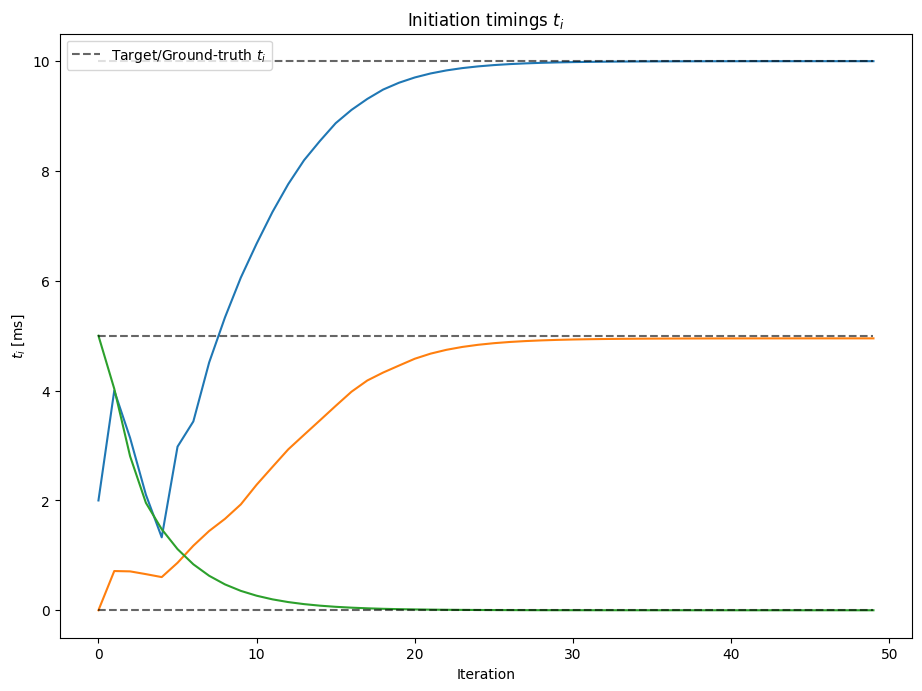

In [14]:
fig = plt.figure()
plt.title("Initiation timings $t_i$")
plt.plot(ti_over_time)
#plt.gca().set_prop_cycle(None) #Reset the color cycle
target_ti_h = plt.plot(np.arange(ti_over_time.shape[0]), np.tile(ti_ground_truth, [ti_over_time.shape[0], 1]), linestyle='--', color='k', alpha=.6)
plt.xlabel("Iteration")
plt.ylabel("$t_i$ [ms]")
plt.legend(target_ti_h, ["Target/Ground-truth $t_i$"])
fig.show()

/home/thomas/anaconda3/envs/geasi_grid_demo/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


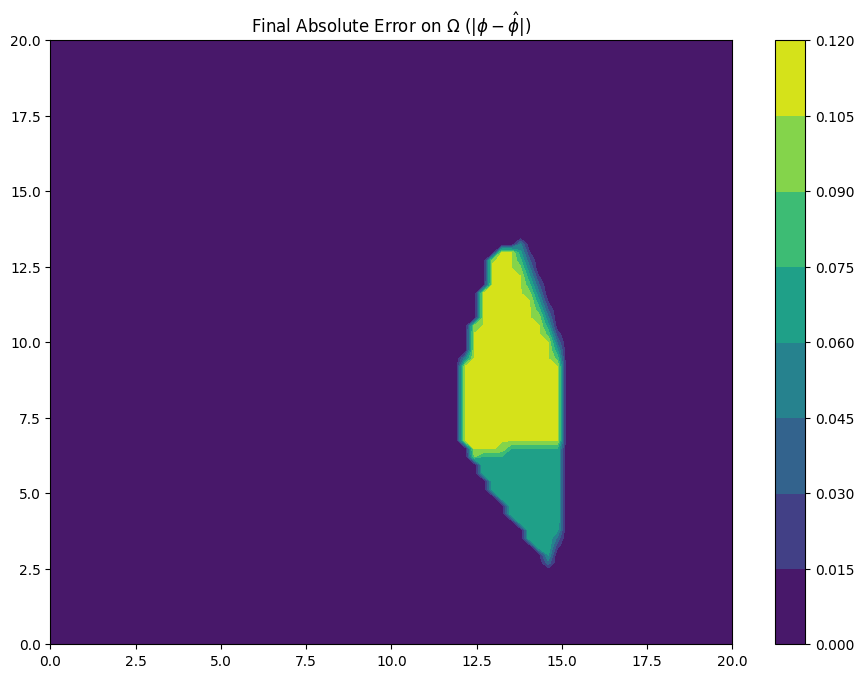

In [15]:
fig = plt.figure()
plt.title("Final Absolute Error on $\Omega$ ($|\phi - \hat{\phi}|$)")
plt.contourf(grid[..., 0], grid[..., 1], np.abs(phi_current - phi_ground_truth))
plt.colorbar()
fig.show()

In [16]:
closest_xi_ind = np.argmin(np.linalg.norm(xi_current[np.newaxis] - xi_ground_truth[:, np.newaxis], axis=-1), axis=1)
xi_dists = np.linalg.norm(xi_current[closest_xi_ind] - xi_ground_truth, axis=-1)
ti_abs_err = np.abs(ti_current[closest_xi_ind] - ti_ground_truth)

print("x_i final distance error: ", xi_dists, " [mm]")
print("t_i final absolute error: ", ti_abs_err, " [ms]")

x_i final distance error:  [1.01886142e-06 3.02503753e-02 1.46728387e-05]  [mm]
t_i final absolute error:  [7.49189667e-06 4.81321303e-02 5.62983985e-05]  [ms]
